In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme()
url = '../datasets/tidy_data_Part_2_Q4.csv'

In [9]:
df = pd.read_csv(url)

In [10]:
df = df[['season','distance','angle','result_event']]
df = df[df['season']!=20192020]

406609
332742


In [100]:
df_shuffled=df.sample(frac=1).reset_index(drop=True)
# df_shuffled = df_shuffled.drop(df_shuffled[df_shuffled['result_event'] == 'Shot'].sample(frac=.9).index)

In [101]:
X = df_shuffled[['distance','angle']].values
Y = df_shuffled['result_event'].values
def convert_to_float(X):
    if X == "Goal":
        return 1.0
    else:
        return 0.0
convert_to_float_v = np.vectorize(convert_to_float)
Y = convert_to_float_v(Y)

In [102]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X,Y)
model = XGBClassifier()
model.fit(X_train,y_train)


C:\Users\xavie\anaconda3\envs\ift6758-conda-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:40:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [103]:
predictions = model.predict(X_val)
accuracy = (predictions == y_val).mean()
print(predictions.all()==0)
print('Accuracy',accuracy)

True
Accuracy 0.9058375207366625


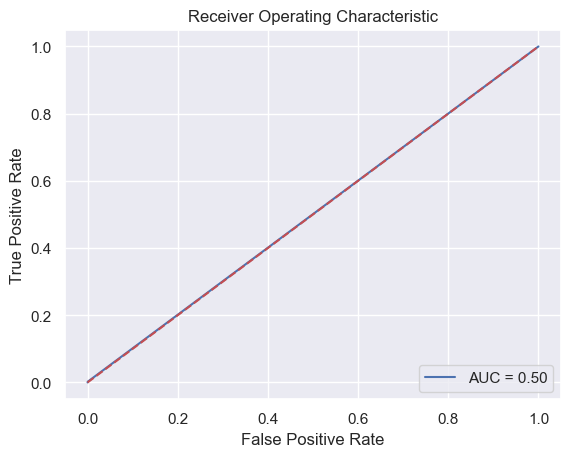

In [104]:
from sklearn import metrics
import matplotlib.pyplot as plt
def buildROC(target_test,test_preds):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
#     plt.gcf().savefig('roc.png')
buildROC(y_val,predictions)

0.92025423


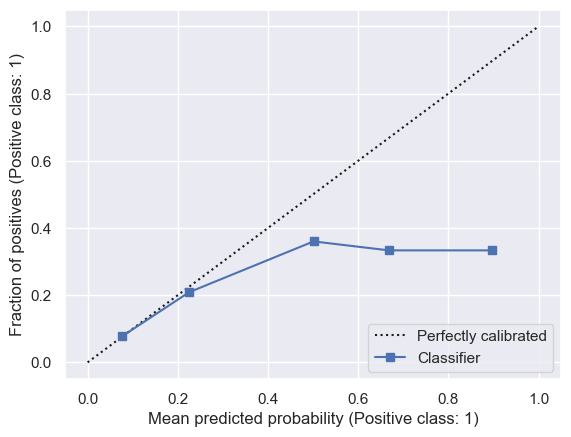

In [105]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X,Y)
model = XGBRegressor()
model.fit(X_train,y_train)

y_prob = np.clip(model.predict(X_val),0.0,1.0)
print(y_prob.max())
from sklearn.calibration import CalibrationDisplay
disp = CalibrationDisplay.from_predictions(y_val, y_prob)
plt.show()

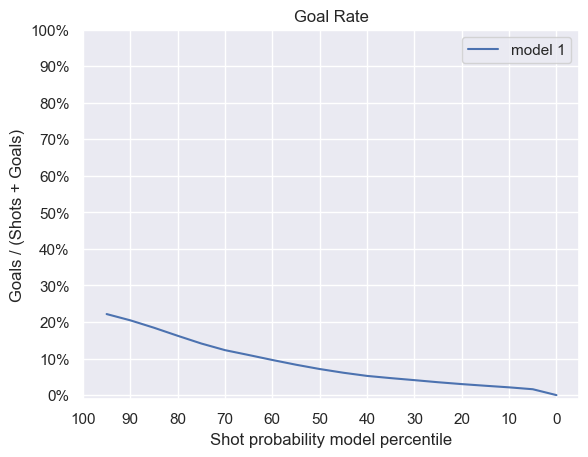

In [111]:
import matplotlib.ticker as mtick
centiles = range(0,99,5)

value = np.percentile(y_prob,range(0,100,5))   

plt.title('Goal Rate')
plt.ylabel('Goals / (Shots + Goals)')
plt.xlabel('Shot probability model percentile')

plt.plot(np.array(centiles)/100.0,value,label='model 1')
plt.legend()
plt.gca().invert_xaxis()

# fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
# yticks = mtick.FormatStrFormatter(fmt)
ys = range(0,101,10)
yticks= [str(y)+'%' for y in ys]
plt.yticks(np.array(ys)/100,yticks)
plt.xticks(np.array(ys)/100,ys)
plt.show()

In [187]:
centiles = range(0,99,98)
y = np.percentile(y_prob,centiles)
print(y)
area_1=np.trapz(y,x=centiles)

area = np.trapz(y, dx=0.61869385)
print("area =", area_1)

[0.         0.24285041]
area = 11.899669989943504


1.7271871455013752
[0.         0.01608537 0.0373594  0.06295927 0.09309744 0.12833946
 0.1693222  0.21584048 0.26839314 0.32961595 0.40100682 0.48415069
 0.58026839 0.68997676 0.81300818 0.95415394 1.1164978  1.30082912
 1.5054295  1.72718715]


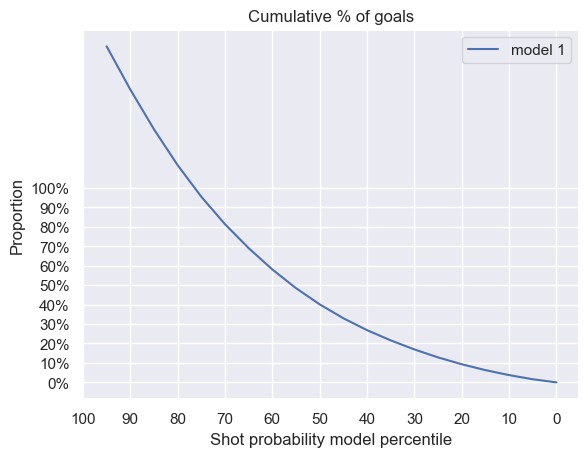

In [144]:

value = np.percentile(y_prob,centiles)
cumulative_sum = np.cumsum(value)
print(np.sum(value))
print(cumulative_sum)
# cumulative_sum = [value[-1]]
# print(value)
# last  = value[-1]
# total = value[-1]
# for i in range(len(value)-2,-1,-1):
#     total += last-value[i]
#     cumulative_sum.append(total)
#     last = value[i]
# print(cumulative_sum)
    
plt.title('Cumulative % of goals')
plt.ylabel('Proportion')
plt.xlabel('Shot probability model percentile')

plt.plot(np.array(centiles)/100.0,cumulative_sum,label='model 1')
plt.legend()
plt.gca().invert_xaxis()

ys = range(0,101,10)
yticks= [str(y)+'%' for y in ys]
plt.yticks(np.array(ys)/100,yticks)
plt.xticks(np.array(ys)/100,ys)
plt.show()